In [ ]:
import numpy as np
import pandas as pd
import scipy.stats
from matplotlib import pyplot

$$\textbf{ Readmission Prediction for Healthcare System}$$

The government is about to initiate the Hospital Readmissions Reduction Program (HRRP) under which hospitals receive a financial penalty if a patient comes back to the hospital within 30 days after discharge. In response, KAIST medical center is considering to introduce *CareTracker* program that helps reducing the probability of readmission through a combination of patient education and monitoring.

We want to establish a rule to decide per patient whether to provide CareTracker given patient information.
We are given a dataset that tells us which patients got readmitted within 30 days.


In [ ]:
data = pd.read_csv("readmission.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The dataset contains information about 4382 medical cases: for each case, it contains the following information

*   `age`: patient's age
*   `female`: patient's gender
*   `flu_season`: whether the case was during the flu season
*   `ed_admit`: whether the case was an emergency admission
*   `severity_score`: the level of severity
*   `comorbidity_score`: the level of comorbidity
*   `readmit30`: whether the patient was readmitted within 30 days



In [ ]:
data.head()
data.max()

,0
age,105
female,1
flu_season,1
ed_admit,1
severity_score,112
comorbidity_score,322
readmit30,1


In [ ]:
X = data.drop( "readmit30", axis=1 )
y = data.readmit30

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=0)

$$\textbf{Classifier design & evaluation}$$


1.   *Severity-based classifier* that predicts a readmission if the value of *severity_score* exceeds a certain threshold.
2.   *Logistic classifier* that makes a prediction using the logistic model.
3.   *$k$-NN classifier* ($k=64$) that makes a prediction using $k$ nearest neighbors algorithm.

For each classifier, trained the model using the training dataset (severity-based classifier does not need training) and evaluated their perforance using the test dataset in a form of ROC curve and AUC value:





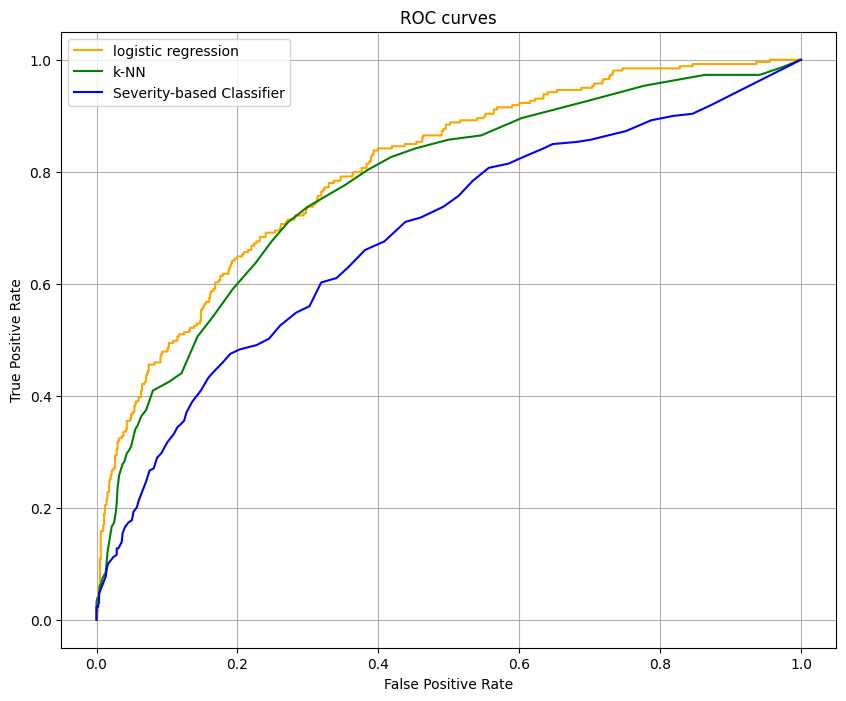

Severity-based classifier: AUC = 0.683165
Logistic classifier: AUC = 0.644838
k-NN classifier: AUC = 0.620478


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score



# severity_threshold=20
# severity_score=X_train['severity_score']
# severity_threshold=severity_score[y_train==1].mean()

y_sev=X_test['severity_score'].values/112.0



model1 = LogisticRegression(random_state=0)
model2 = KNeighborsClassifier(n_neighbors=64)
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
y1_prob=model1.predict_proba(X_test)[:,1]
y2_prob=model2.predict_proba(X_test)[:,1]

# ROC curves
xaxis1,yaxis1,_=roc_curve(y_test, y1_prob)
xaxis2,yaxis2,_=roc_curve(y_test, y2_prob)
xaxis3,yaxis3,_=roc_curve(y_test, y_sev)
pyplot.figure(figsize=(10,8))
pyplot.plot(xaxis1,yaxis1,label="logistic regression",c="orange")
pyplot.plot(xaxis2,yaxis2,label="k-NN", c="green")
pyplot.plot(xaxis3,yaxis3,label="Severity-based Classifier", c="blue")
pyplot.xlabel("False Positive Rate")
pyplot.ylabel("True Positive Rate")
pyplot.title("ROC curves")
pyplot.legend(loc="best")
pyplot.grid()
pyplot.show()

#  AUC values
Accuracy1=roc_auc_score(y_test, y1)
Accuracy2=roc_auc_score(y_test, y2)
sev_accuracy=roc_auc_score(y_test, y_sev)

print( "Severity-based classifier: AUC = %f" % sev_accuracy )
print( "Logistic classifier: AUC = %f" % Accuracy1 )
print( "k-NN classifier: AUC = %f" % Accuracy2 )

$$\textbf{ Optimal thresholds}$$

A pilot study on CareTracker shows that

*   CareTracker cost per patient: \$1,200
*   CareTracker reduces readmission probability by 40% (i.e., if 100 patients were readmitted without CareTracker, only 60 patients would be with CareTracker)
*   Penalty per readmitted patient imposed by Government: \$8,000

For example, if a patient is the one who will be readmitted without CareTracker, CareTracker can reduce the cost from \$8000 to \$6000 ($=\$1200+0.6 \times \$8000 $).

Note that a classifier immediately leads to a decision rule: CareTracker is provided to a patient if and only if the classifier predicts the patient will be readmitted without CareTracker.

For each deicion rule, we will compute the total cost on the test dataset while varying the threshold value, and find out the optimal threshold at which the cost is minimized.

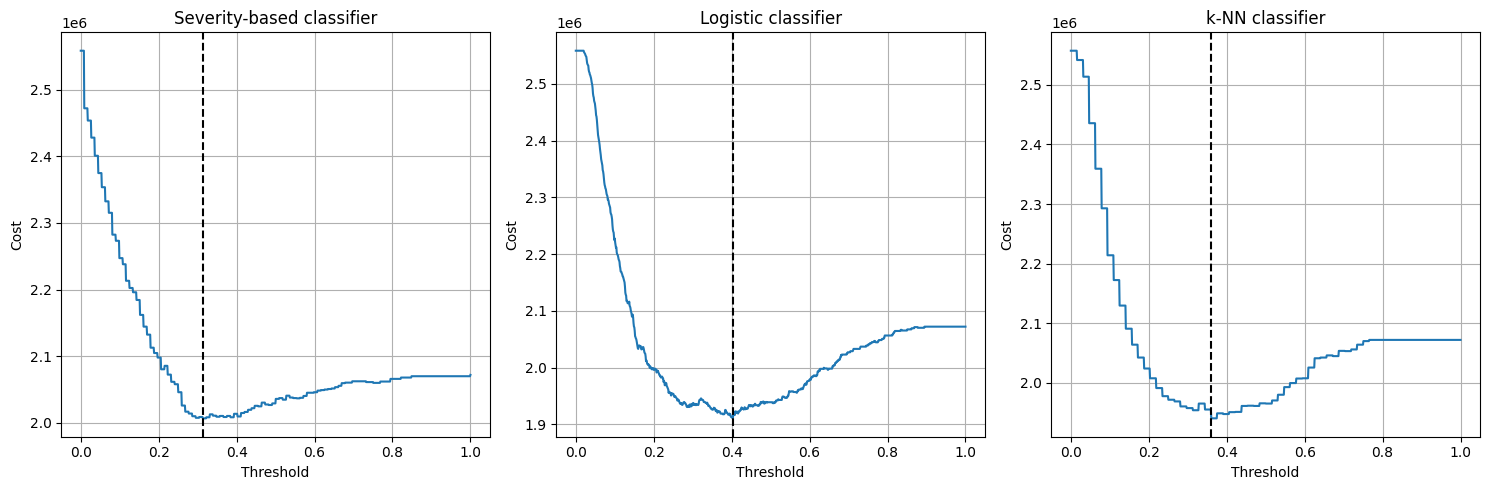

Severity-based classifier: minimum cost = 2006800.000000, optimal threshold = 0.313313
Logistic classifier: minimum cost = 1910400.000000, optimal threshold = 0.402402
k-NN classifier: minimum cost = 1940400.000000, optimal threshold = 0.360360


In [ ]:

thresholds=np.linspace(0,1,1000)
y_test=y_test[:].values
def cost(y_prob,threshold):
  cost =0
  for i in range(len(y_prob)):
    if y_prob[i]>threshold:
      cost+=1200
      if y_test[i]==1:
        cost+=0.6*8000
    else:
      if y_test[i]==1:
        cost+=8000


  return cost

y_prob_sev=y_sev
y_prob_log=y1_prob
y_prob_knn=y2_prob
cost_sev=[]
cost_log=[]
cost_knn=[]
for threhsold in thresholds:
  cost_sev.append(cost(y_prob_sev,threhsold))
  cost_log.append(cost(y_prob_log,threhsold))
  cost_knn.append(cost(y_prob_knn,threhsold))
min_cost_sev=min(cost_sev)
threshold_sev=thresholds[cost_sev.index(min_cost_sev)]
min_cost1=min(cost_log)
threshold_1=thresholds[cost_log.index(min_cost1)]
min_cost2=min(cost_knn)
threshold_2=thresholds[cost_knn.index(min_cost2)]

pyplot.figure(figsize=(15,5))
pyplot.subplot(1,3,1)
pyplot.plot(thresholds,cost_sev)
pyplot.title('Severity-based classifier')
pyplot.xlabel('Threshold')
pyplot.ylabel('Cost')
pyplot.axvline(x=threshold_sev,color='black',linestyle='--')
pyplot.grid(True)

pyplot.subplot(1,3,2)
pyplot.plot(thresholds,cost_log)
pyplot.title('Logistic classifier')
pyplot.xlabel('Threshold')
pyplot.ylabel('Cost')
pyplot.axvline(x=threshold_1,color='black',linestyle='--')
pyplot.grid(True)

pyplot.subplot(1,3,3)
pyplot.plot(thresholds,cost_knn)
pyplot.title('k-NN classifier')
pyplot.xlabel('Threshold')
pyplot.ylabel('Cost')
pyplot.axvline(x=threshold_2,color='black',linestyle='--')
pyplot.grid(True)

pyplot.tight_layout()
pyplot.show()



print( "Severity-based classifier: minimum cost = %f, optimal threshold = %f" % (min_cost_sev, threshold_sev) )
print( "Logistic classifier: minimum cost = %f, optimal threshold = %f" % (min_cost1,threshold_1) )
print( "k-NN classifier: minimum cost = %f, optimal threshold = %f" % (min_cost2,threshold_2) )